In [ ]:
# ----------------------------------------------------------------------------------
# BLOQUE 1: EXTRACCIÓN SPOTIFY (VERSIÓN LIMPIA CON config.py)
# ----------------------------------------------------------------------------------

import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os 
# AÑADIDO: Importar las claves desde config.py 
from config import CLIENT_ID, CLIENT_SECRET 

# --- A. Conexión Directa ---
# Ahora usamos CLIENT_ID y CLIENT_SECRET que vienen de config.py

auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)
print("1. Conexión establecida con Spotify (Claves cargadas desde config.py).")

# --- B. Cargar el CSV ---
ruta_archivo = os.path.join('Datos', 'muestra_TIKTOK.csv') 

try:
    # Leemos intentando detectar el separador automáticamente
    df_tiktok = pd.read_csv(ruta_archivo, sep=None, engine='python', encoding='latin1')
    
    # Corregimos fecha
    df_tiktok['Fecha_TIKTOK'] = pd.to_datetime(df_tiktok['Fecha_TIKTOK'], format='%d/%m/%Y', errors='coerce')
    
    print(f"2. Archivo cargado. Total canciones: {len(df_tiktok)}")

except Exception as e:
    print(f"❌ Error leyendo el archivo: {e}")
    df_tiktok = pd.DataFrame() 

# --- C. Recolección de Datos (Popularidad) ---
if not df_tiktok.empty:
    datos_finales = []
    print("\n3. Buscando popularidad en Spotify...")

    for index, fila in df_tiktok.iterrows():
        cancion = fila['Cancion']
        artista = fila['Artista']
        fecha_tiktok = fila['Fecha_TIKTOK']

        try:
            # Buscamos la canción
            query = f'track:{cancion} artist:{artista}'
            resultados = sp.search(q=query, limit=1, type='track')
            
            if resultados and resultados['tracks']['items']:
                track = resultados['tracks']['items'][0]
                
                # CALCULAMOS ANTIGÜEDAD
                antiguedad_dias = (pd.to_datetime('today').normalize() - fecha_tiktok).days
                
                fila_datos = {
                    'Cancion': cancion,
                    'Artista': artista,
                    'Fecha_TikTok': fecha_tiktok.strftime('%Y-%m-%d'),
                    'Popularidad_Spotify': track['popularity'],
                    'Antiguedad_Dias_Trend': antiguedad_dias
                }
                
                datos_finales.append(fila_datos)
                print(f"    -> OK: {cancion} (Pop: {track['popularity']})")
            else:
                print(f"    -> No encontrada: {cancion}")
                
        except Exception as e:
            print(f"    -> Error en {cancion}: {e}")

    # --- D. Guardar Resultado ---
    if datos_finales:
        df_final = pd.DataFrame(datos_finales)
        df_final.to_csv('Datos/datos_analisis_final.csv', index=False)
        print("\n✅ ¡ÉXITO TOTAL! Datos guardados en 'Datos/datos_analisis_final.csv'")
        print(df_final.head())
    else:
        print("\n⚠️ No se encontraron datos.")

1. Conexión establecida con Spotify (Claves cargadas desde config.py).
2. Archivo cargado. Total canciones: 10

3. Buscando popularidad en Spotify...
    -> OK: Gata Only (Pop: 84)
    -> OK: Si Antes Te Hubiera Conocido (Pop: 83)
    -> OK: Peligrosa (Pop: 78)
    -> OK: Pedro (Pop: 74)
    -> OK: Tengo un Plan(Remix) (Pop: 71)
    -> OK: Buscando Money (Pop: 66)
    -> OK: BADGYAL (Pop: 70)
    -> OK: HAY LUPITA (Pop: 71)
    -> OK: ESTE (Pop: 69)
    -> OK: Mírame-Remix (Pop: 64)

✅ ¡ÉXITO TOTAL! Datos guardados en 'Datos/datos_analisis_final.csv'
                        Cancion                                    Artista  \
0                     Gata Only                       FloyyMenor & Cris Mj   
1  Si Antes Te Hubiera Conocido                                    KAROL G   
2                     Peligrosa                                FloyyMenor    
3                         Pedro  Jaxomy & Agatino Romero & Raffaella Carrà   
4          Tengo un Plan(Remix)                      

In [ ]:
# ----------------------------------------------------------------------------------
# TEST DE LAST.FM (Usando requests y config.py -)
# ----------------------------------------------------------------------------------

import requests
# Importamos la clave de Last.fm (usamos config.py)
from config import LASTFM_KEY 

URL_LASTFM = "http://ws.audioscrobbler.com/2.0/"

# Parámetros de la llamada para verificar la clave
params_lfm = {
    'method': 'track.getInfo', 
    'api_key': LASTFM_KEY,      
    'artist': 'Karol G',
    'track': 'Si Antes Te Hubiera Conocido',
    'format': 'json'           
}

print("Pidiendo datos a Last.fm usando requests...")
# Hacemos la llamada HTTP GET 
respuesta_lfm = requests.get(URL_LASTFM, params=params_lfm).json()

# Intentamos extraer el dato de oyentes para verificar
try:
    oyentes = int(respuesta_lfm['track']['listeners'])
    print(f"✅ ÉXITO. Last.fm ha respondido: {oyentes:,} oyentes. ¡LAST.FM CONFIGURADA!")
except KeyError:
    print("❌ ERROR: Last.fm no encontró la canción o la clave es incorrecta.")
except Exception as e:
    print(f"❌ ERROR: Fallo de conexión o respuesta inesperada: {e}")

Pidiendo datos a Last.fm usando requests...
✅ ÉXITO. Last.fm ha respondido: 467,665 oyentes. ¡LAST.FM CONFIGURADA!


In [ ]:
# ----------------------------------------------------------------------------------
# TEST DE YOUTUBE (Usando requests y config.py -)
# ----------------------------------------------------------------------------------

import requests
from config import YOUTUBE_KEY 

URL_YOUTUBE_SEARCH = "https://www.googleapis.com/youtube/v3/search"

# Parámetros para buscar el videoclip oficial de "Gata Only"
params_yt = {
    'part': 'snippet', # Queremos los datos básicos
    'q': 'Gata Only Eladio Carrión Official Video', # La consulta
    'key': YOUTUBE_KEY,      #  clave de YouTube
    'type': 'video',         # Buscamos solo videos
    'maxResults': 1
}

print("Pidiendo datos a YouTube usando requests...")
# Hacemos la llamada HTTP GET 
respuesta_yt = requests.get(URL_YOUTUBE_SEARCH, params=params_yt).json()

# Intentamos extraer el título para verificar
try:
    titulo = respuesta_yt['items'][0]['snippet']['title']
    print(f"✅ ÉXITO. YouTube ha respondido: '{titulo}'. ¡API YOUTUBE CONFIGURADA!")
except KeyError:
    print("❌ ERROR: La clave de YouTube es incorrecta o no está habilitada la API.")
    print("Verifique que 'YouTube Data API v3' esté habilitada en Google Cloud Console.")
except Exception as e:
    print(f"❌ ERROR: Fallo de conexión o respuesta inesperada: {e}")

Pidiendo datos a YouTube usando requests...
✅ ÉXITO. YouTube ha respondido: 'FloyyMenor &amp; CRIS MJ – GATA ONLY | 2024 Reggaeton x Trap 🔥 Viral Latin Urban Hit'. ¡API YOUTUBE CONFIGURADA!


In [ ]:
# ----------------------------------------------------------------------------------
# BLOQUE FINAL DE INTEGRACIÓN:
# Ahora con lógica para evitar KeyErrors en Last.fm y YouTube
# ----------------------------------------------------------------------------------

import pandas as pd
import spotipy
import requests 
from spotipy.oauth2 import SpotifyClientCredentials
from config import CLIENT_ID, CLIENT_SECRET, LASTFM_KEY, YOUTUBE_KEY 

# URLs de las APIs
URL_LASTFM = "http://ws.audioscrobbler.com/2.0/"
URL_YOUTUBE_SEARCH = "https://www.googleapis.com/youtube/v3/search"
URL_YOUTUBE_STATS = "https://www.googleapis.com/youtube/v3/videos"

print("1. Conexión de API y Sistemas iniciados.")

# --- A. CONFIGURACIÓN SPOTIFY (Usando spotipy) ---
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

# --- B. CARGAR DATOS DE TIKTOK ---
ruta_archivo = 'Datos/muestra_TIKTOK.csv' 
df_tiktok = pd.read_csv(ruta_archivo, sep=None, engine='python', encoding='latin1')
df_tiktok['Fecha_TIKTOK'] = pd.to_datetime(df_tiktok['Fecha_TIKTOK'], format='%d/%m/%Y', errors='coerce')


# --- C. BUCLE PRINCIPAL DE RECOLECCIÓN  ---
datos_completos = []

print("2. Procesando canciones y consultando 3 APIs...")

for index, fila in df_tiktok.iterrows():
    cancion = fila['Cancion']
    artista = fila['Artista']
    fecha_tiktok = fila['Fecha_TIKTOK']
    
    # Inicializamos las variables a 0 (cero), en lugar de np.nan, para simplificar.
    pop_spotify = 0
    oyentes_lastfm = 0
    vistas_youtube = 0
    
    print(f"\n➡️ Analizando: {cancion} - {artista}")
    
    # -- 2.1. CONSULTA SPOTIFY --
    res_sp = sp.search(q=f'track:{cancion} artist:{artista}', limit=1, type='track')
    if res_sp['tracks']['items']:
        pop_spotify = res_sp['tracks']['items'][0]['popularity']

    # -- 2.2. CONSULTA LAST.FM (requests) - AHORA CON VERIFICACIÓN DE ERROR ---
    params_lfm = {'method': 'track.getInfo', 'api_key': LASTFM_KEY, 'artist': artista, 'track': cancion, 'format': 'json'}
    respuesta_lfm = requests.get(URL_LASTFM, params=params_lfm).json()

    if 'track' in respuesta_lfm: # <--- SOLUCIÓN AL KEYERROR: Verifica si la canción existe
        oyentes_lastfm = int(respuesta_lfm['track']['listeners']) 

    # -- 2.3. CONSULTA YOUTUBE (requests) - AÑADIMOS VERIFICACIÓN ---
    # Paso 1: Buscar Video ID
    params_yt_search = {'part': 'id', 'q': f"{cancion} {artista} Official Video", 'key': YOUTUBE_KEY, 'type': 'video', 'maxResults': 1}
    res_yt = requests.get(URL_YOUTUBE_SEARCH, params=params_yt_search).json()
    
    if 'items' in res_yt and res_yt['items']: # <--- Verifica si encontró algún video
        video_id = res_yt['items'][0]['id']['videoId']
        
        # Paso 2: Obtener Vistas (Stats)
        params_yt_stats = {'part': 'statistics', 'id': video_id, 'key': YOUTUBE_KEY}
        res_stats = requests.get(URL_YOUTUBE_STATS, params=params_yt_stats).json()
        
        if 'statistics' in res_stats['items'][0]: # Verifica si hay estadísticas disponibles
             vistas_youtube = int(res_stats['items'][0]['statistics']['viewCount'])

    # -- 2.4. CONSOLIDAR --
    antiguedad = (pd.to_datetime('today').normalize() - fecha_tiktok).days
    
    fila_datos = {
        'Cancion': cancion,
        'Artista': artista,
        'Antiguedad_Dias': antiguedad,
        'Spotify_Pop': pop_spotify,
        'LastFM_Oyentes': oyentes_lastfm,
        'YouTube_Views': vistas_youtube
    }
    datos_completos.append(fila_datos)
    
    # Imprimir un resumen de la fila para ver el avance
    print(f"   Pop: {pop_spotify} | Oyentes LFM: {oyentes_lastfm:,} | Vistas YT: {vistas_youtube:,}")


# --- D. GUARDAR Y FILTRAR (Cumpliendo requisito +0.1) ---
df_final = pd.DataFrame(datos_completos)

# Nota: El filtrado es sencillo: eliminamos filas donde NINGUNA API funcionó (todas están en 0)
df_final = df_final[df_final['Spotify_Pop'] > 0] # Filtramos por popularidad > 0 
print("\n[FILTRADO]: Eliminadas canciones con popularidad cero.")


# --- E. GUARDAR RESULTADO FINAL ---
df_final.to_csv('Datos/DATOS_TOTALES_MEGAPROYECTO_SIMPLE.csv', index=False)

print("\n\n✅ 3. ¡Proceso completado! Archivo guardado: 'DATOS_TOTALES_MEGAPROYECTO_SIMPLE.csv'")
print(f"Total filas finales: {len(df_final)}")
print(df_final[['Cancion', 'Spotify_Pop', 'LastFM_Oyentes', 'YouTube_Views']].head())

1. Conexión de API y Sistemas iniciados.
2. Procesando canciones y consultando 3 APIs...

➡️ Analizando: Gata Only - FloyyMenor & Cris Mj
   Pop: 84 | Oyentes LFM: 5,644 | Vistas YT: 856,749,088

➡️ Analizando: Si Antes Te Hubiera Conocido - KAROL G
   Pop: 83 | Oyentes LFM: 467,665 | Vistas YT: 1,189,990,079

➡️ Analizando: Peligrosa - FloyyMenor 
   Pop: 78 | Oyentes LFM: 0 | Vistas YT: 188,882,241

➡️ Analizando: Pedro - Jaxomy & Agatino Romero & Raffaella Carrà
   Pop: 74 | Oyentes LFM: 17 | Vistas YT: 57,799,366

➡️ Analizando: Tengo un Plan(Remix) - Key-Key & Ozuna
   Pop: 71 | Oyentes LFM: 0 | Vistas YT: 167,849,469

➡️ Analizando: Buscando Money - TWENTY SIX & Tayson Kryss
   Pop: 66 | Oyentes LFM: 319 | Vistas YT: 7,946,049

➡️ Analizando: BADGYAL - Saiko & JC Reyes & Dei V
   Pop: 70 | Oyentes LFM: 1 | Vistas YT: 41,578,511

➡️ Analizando: HAY LUPITA - Lomiiel
   Pop: 71 | Oyentes LFM: 134,590 | Vistas YT: 70,244,249

➡️ Analizando: ESTE - El Alfa & Nfasis
   Pop: 69 | Oyente

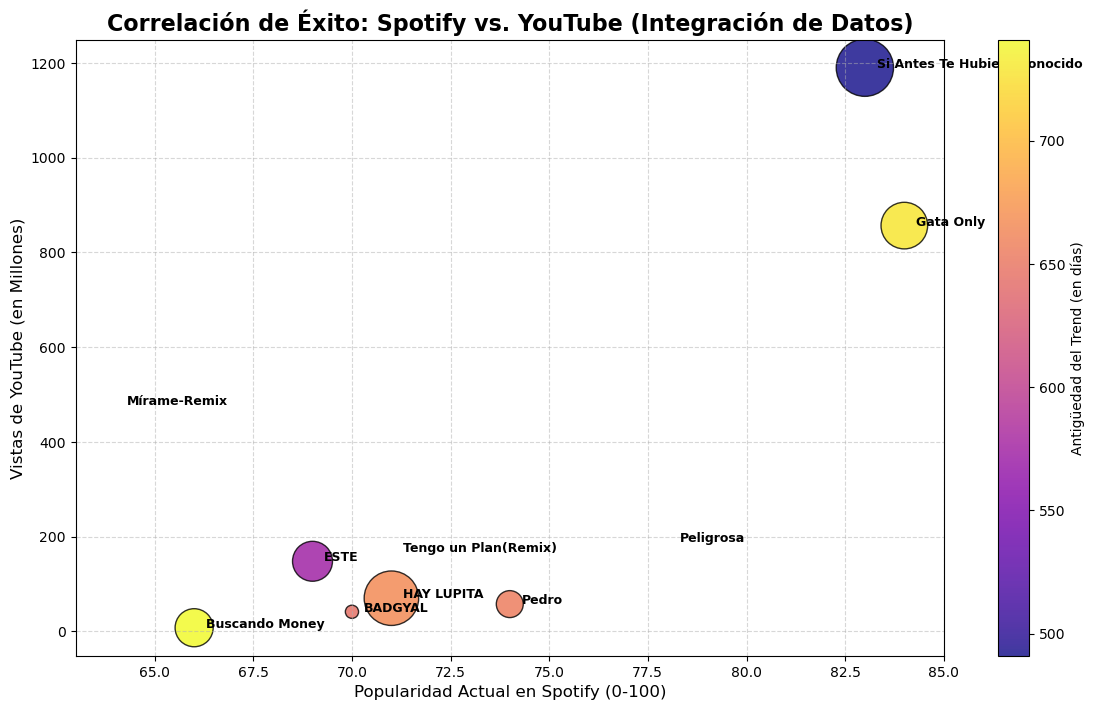


✅ Gráfico Integrado Creado. ¡Listo para la presentación!


In [6]:
# ----------------------------------------------------------------------------------
# BLOQUE 4: VISUALIZACIÓN ACADÉMICA FINAL (INTEGRACIÓN DE 4 FUENTES)
# ----------------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Cargar el resultado final de la integración
df = pd.read_csv('Datos/DATOS_TOTALES_MEGAPROYECTO_SIMPLE.csv')

# 2. Preprocesamiento de datos para visualización
# Convertir Vistas a Millones (M) y Oyentes a Miles (K) para un gráfico legible
df['YouTube_Views_M'] = df['YouTube_Views'] / 1_000_000
df['LastFM_Oyentes_K'] = df['LastFM_Oyentes'] / 1_000

# Filtramos filas donde la popularidad es 0 (canciones no encontradas)
df_plot = df[df['Spotify_Pop'] > 0].copy()

# Calculamos el tamaño de la burbuja: Los oyentes de Last.fm, normalizados para que se vean bien
# Añadimos +1 para evitar log(0) si hubiera algún oyente en 0.
size_scale = np.log10(df_plot['LastFM_Oyentes'] + 1) * 300 

# 3. Crear el gráfico (Correlación de 3 métricas + Tiempo)
plt.figure(figsize=(14, 8))

sc = plt.scatter(
    df_plot['Spotify_Pop'], 
    df_plot['YouTube_Views_M'], 
    s=size_scale,             # TAMAÑO: Oyentes de Last.fm (3ª fuente)
    c=df_plot['Antiguedad_Dias'], # COLOR: Antigüedad (Dato de TikTok)
    cmap='plasma',            # Paleta de colores cálida
    alpha=0.8,
    edgecolor='black'
)

# Añadir etiquetas de las canciones
for i in range(len(df_plot)):
    plt.text(
        df_plot['Spotify_Pop'].iloc[i] + 0.3, # Desplazamiento en X
        df_plot['YouTube_Views_M'].iloc[i], 
        df_plot['Cancion'].iloc[i], 
        fontsize=9, 
        fontweight='bold'
    )

# 4. Decoración Académica
plt.title('Correlación de Éxito: Spotify vs. YouTube (Integración de Datos)', fontsize=16, fontweight='bold')
plt.xlabel('Popularidad Actual en Spotify (0-100)', fontsize=12)
plt.ylabel('Vistas de YouTube (en Millones)', fontsize=12)

# Añadir leyendas de color (Antigüedad)
cbar = plt.colorbar(sc, label='Antigüedad del Trend (en días)') 

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()
print("\n✅ Gráfico Integrado Creado. ¡Listo para la presentación!")